<a href="https://colab.research.google.com/github/Octochic/SMS-Spam-Detection/blob/main/SMS_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loading

In [13]:
!pip install kaggle

In [14]:
!mkdir -p ~/.kaggle

In [15]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset


Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown


In [17]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


Importing Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import pickle
import warnings
warnings.filterwarnings('ignore')

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [21]:
print("Original column names:", df.columns.tolist())

Original column names: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


In [22]:
if 'v1' not in df.columns and 'v2' not in df.columns:
    if 'label' in df.columns and 'message' in df.columns:
        df = df.rename(columns={'label': 'v1', 'message': 'v2'})
    elif 'class' in df.columns and 'text' in df.columns:
        df = df.rename(columns={'class': 'v1', 'text': 'v2'})

In [23]:
if 'v1' not in df.columns or 'v2' not in df.columns:
    print("Warning: Could not identify the correct columns!")
    print("Please confirm the column names and adjust the code.")
else:
    print("Using columns 'v1' for labels and 'v2' for messages.")

Using columns 'v1' for labels and 'v2' for messages.


In [24]:
print("\nDataset Information:")
print(df.info())
print("\nSample Data:")
print(df.head())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None

Sample Data:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN  

Data Preprocessing

In [25]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [26]:
if df['v1'].isnull().sum() > 0 or df['v2'].isnull().sum() > 0:
    print("Handling missing values...")
    df = df.dropna(subset=['v1', 'v2'])

In [27]:
print("\nClass Distribution:")
print(df['v1'].value_counts())
print(df['v1'].value_counts(normalize=True) * 100)


Class Distribution:
v1
ham     4825
spam     747
Name: count, dtype: int64
v1
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


In [28]:
unique_labels = df['v1'].unique()
print(f"Unique labels: {unique_labels}")

Unique labels: ['ham' 'spam']


In [29]:
if not all(label in ['ham', 'spam'] for label in unique_labels):
    print("Standardizing labels...")
    # Map labels to standard format - adjust this based on your actual labels
    label_map = {
        'ham': 'ham',
        'spam': 'spam',
    }
    df['v1'] = df['v1'].map(lambda x: label_map.get(x.lower(), x))

Data Analysis and Visualization

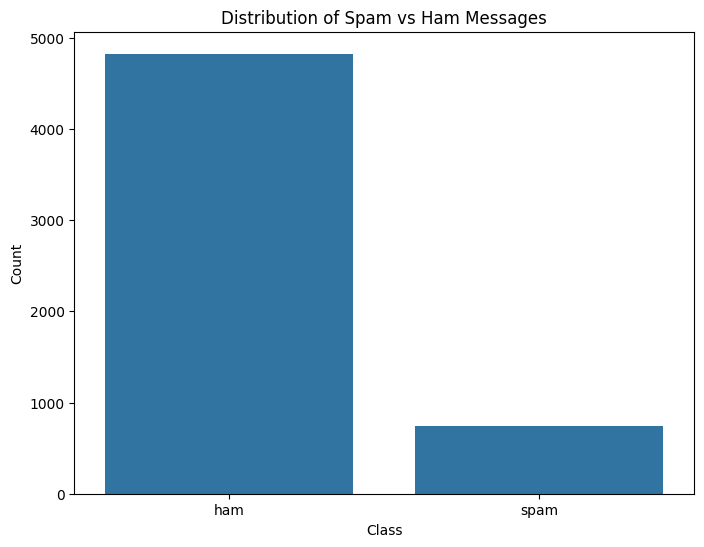

In [30]:
plt.figure(figsize=(8, 6))
sns.countplot(x='v1', data=df)
plt.title('Distribution of Spam vs Ham Messages')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [31]:
df['length'] = df['v2'].apply(len)
print("\nMessage Length Statistics:")
print(df.groupby('v1')['length'].describe())


Message Length Statistics:
       count        mean        std   min    25%    50%    75%    max
v1                                                                   
ham   4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam   747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


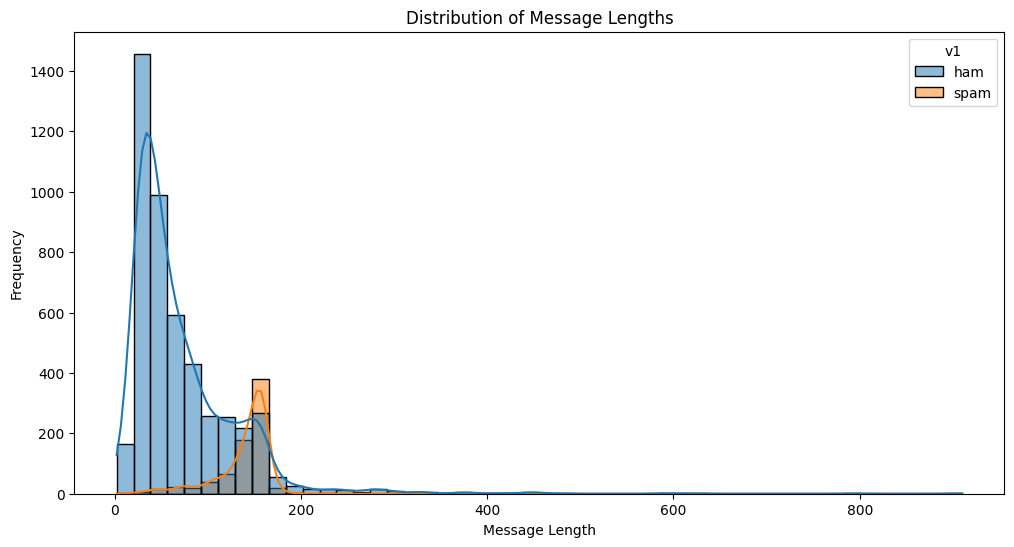

In [32]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='length', hue='v1', bins=50, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

In [33]:
def clean_text(text):
    """Basic text cleaning function"""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = ''.join([char for char in text if char not in string.punctuation])

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()

        return text
    else:
        return ""


Preprocessing

In [34]:
def remove_stopwords(text):
    """Remove stopwords from text"""
    stop_words = set(stopwords.words('english'))
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words])

def stem_text(text):
    """Apply stemming to text"""
    stemmer = PorterStemmer()
    words = text.split()
    return ' '.join([stemmer.stem(word) for word in words])

def lemmatize_text(text):
    """Apply lemmatization to text"""
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

In [35]:
print("\nApplying text preprocessing...")
df['clean_text'] = df['v2'].apply(clean_text)
df['clean_no_stop'] = df['clean_text'].apply(remove_stopwords)
df['stemmed_text'] = df['clean_no_stop'].apply(stem_text)
df['lemmatized_text'] = df['clean_no_stop'].apply(lemmatize_text)


Applying text preprocessing...


In [36]:
print("\nText Preprocessing Example:")
print(df[['v2', 'clean_text', 'clean_no_stop', 'stemmed_text', 'lemmatized_text']].head(2))


Text Preprocessing Example:
                                                  v2  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   

                                          clean_text  \
0  go until jurong point crazy available only in ...   
1                            ok lar joking wif u oni   

                                       clean_no_stop  \
0  go jurong point crazy available bugis n great ...   
1                            ok lar joking wif u oni   

                                        stemmed_text  \
0  go jurong point crazi avail bugi n great world...   
1                              ok lar joke wif u oni   

                                     lemmatized_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  


In [37]:
print("\nPerforming feature engineering...")


Performing feature engineering...


In [38]:
df['text_length'] = df['v2'].apply(lambda x: len(str(x)))
df['word_count'] = df['v2'].apply(lambda x: len(str(x).split()))
df['url_count'] = df['v2'].apply(lambda x: len(re.findall(r'https?://\S+|www\.\S+', str(x))))
df['phone_count'] = df['v2'].apply(lambda x: len(re.findall(r'\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}', str(x))))
df['special_char_count'] = df['v2'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df['special_char_ratio'] = df['special_char_count'] / df['text_length'].apply(lambda x: 1 if x == 0 else x)
df['uppercase_ratio'] = df['v2'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) if len(str(x)) > 0 else 1))

Vectorization

In [39]:
print("\nVectorizing text data...")

# Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000)
count_features = count_vectorizer.fit_transform(df['clean_no_stop'])

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(df['clean_no_stop'])

# N-gram features
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=5000)
bigram_features = bigram_vectorizer.fit_transform(df['clean_no_stop'])

print("\nVector Features Shape:")
print(f"Count Vectorizer: {count_features.shape}")
print(f"TF-IDF Vectorizer: {tfidf_features.shape}")
print(f"Bigram Vectorizer: {bigram_features.shape}")


Vectorizing text data...

Vector Features Shape:
Count Vectorizer: (5572, 5000)
TF-IDF Vectorizer: (5572, 5000)
Bigram Vectorizer: (5572, 5000)


In [40]:
print("\nPreparing data for modeling...")

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['v1'])  # 'spam' becomes 1, 'ham' becomes 0

mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label encoding mapping: {mapping}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining and Testing Data Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Preparing data for modeling...
Label encoding mapping: {'ham': np.int64(0), 'spam': np.int64(1)}

Training and Testing Data Shapes:
X_train: (4457, 5000), y_train: (4457,)
X_test: (1115, 5000), y_test: (1115,)


Model training and Visualization


=== Model Training and Evaluation ===

Training Naive Bayes...

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



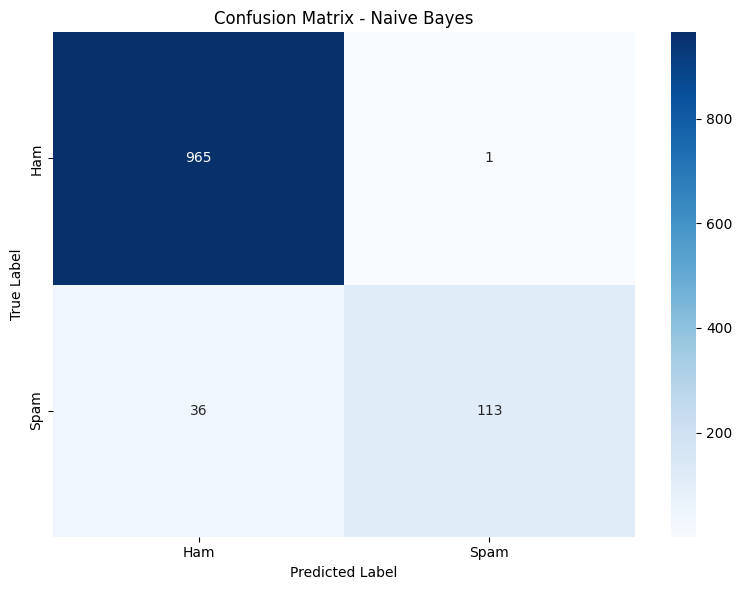

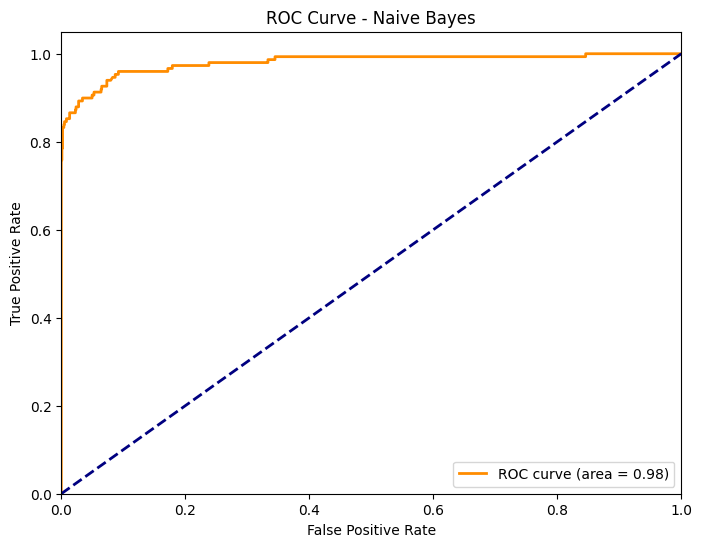


Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.70      0.82       149

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115



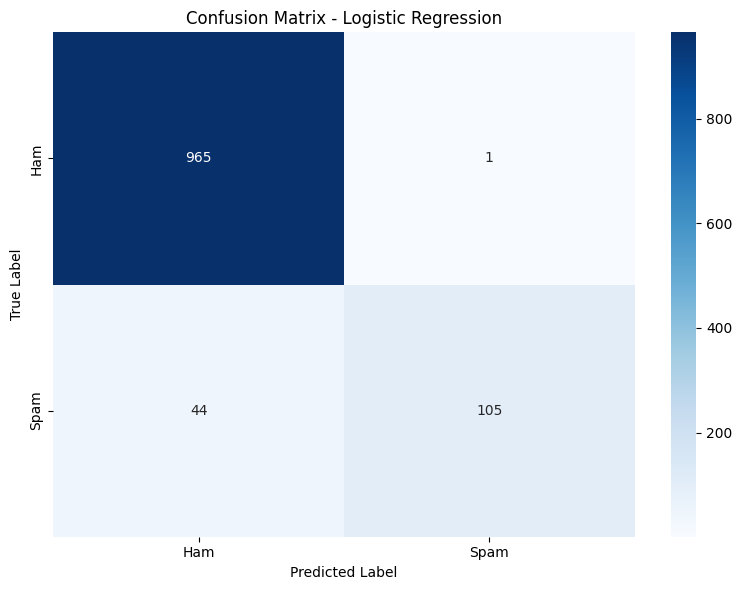

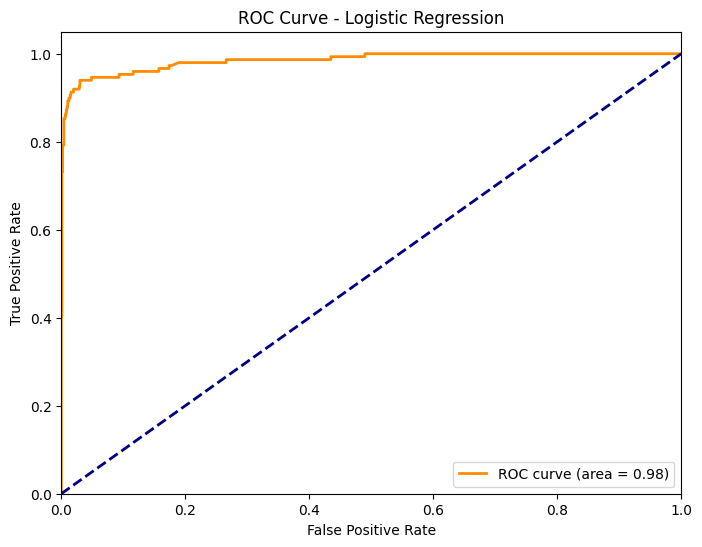


Training SVM...

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



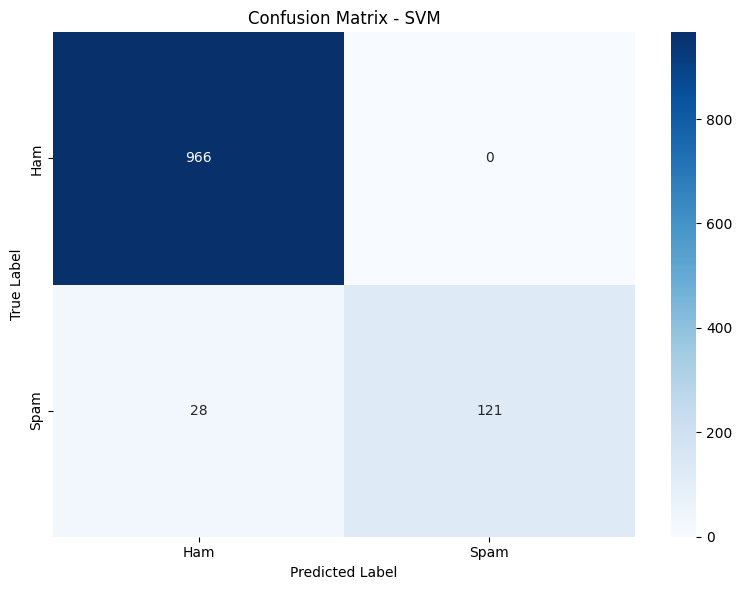

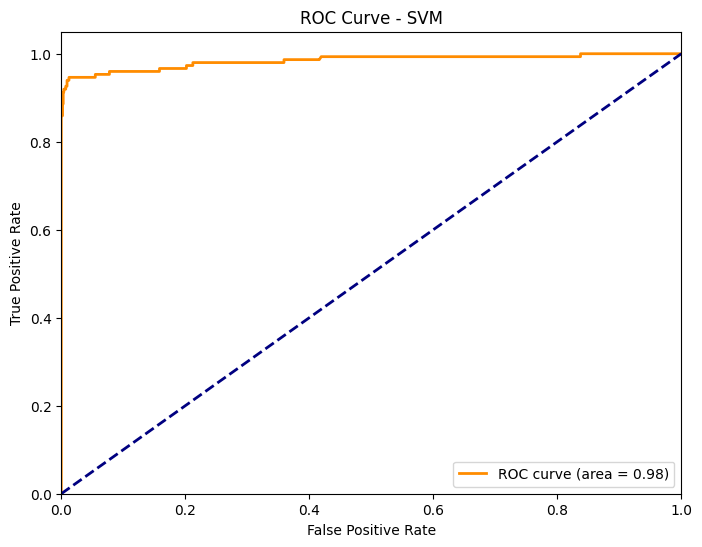


Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



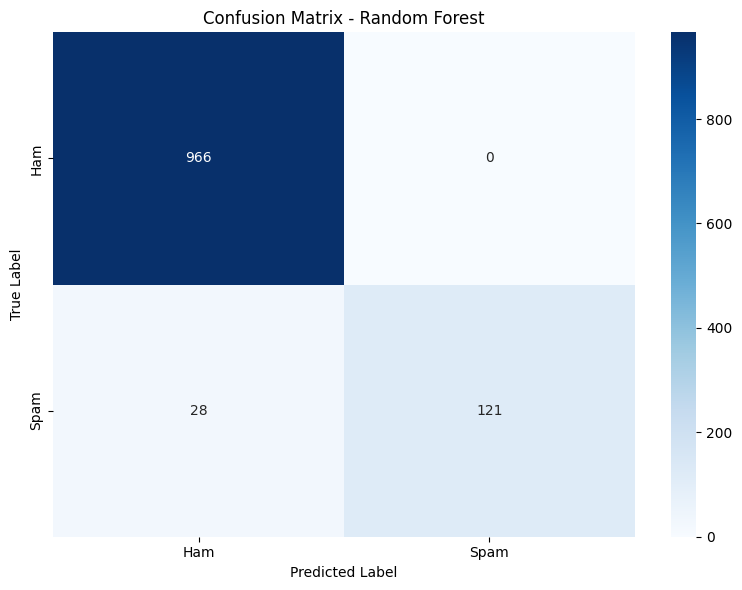

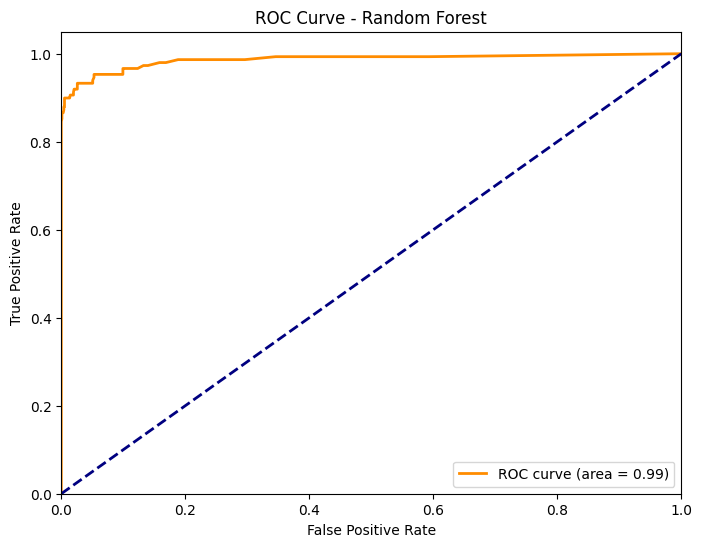


Training Gradient Boosting...

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       966
           1       0.92      0.74      0.82       149

    accuracy                           0.96      1115
   macro avg       0.94      0.86      0.90      1115
weighted avg       0.96      0.96      0.95      1115



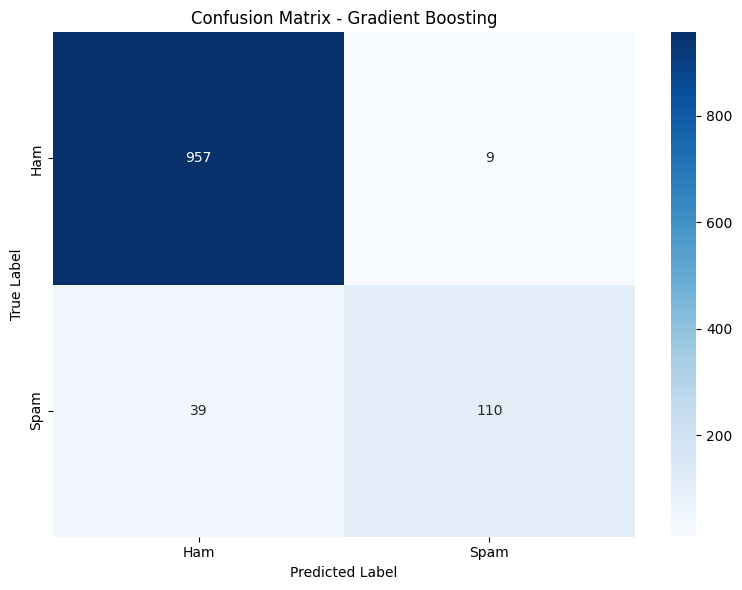

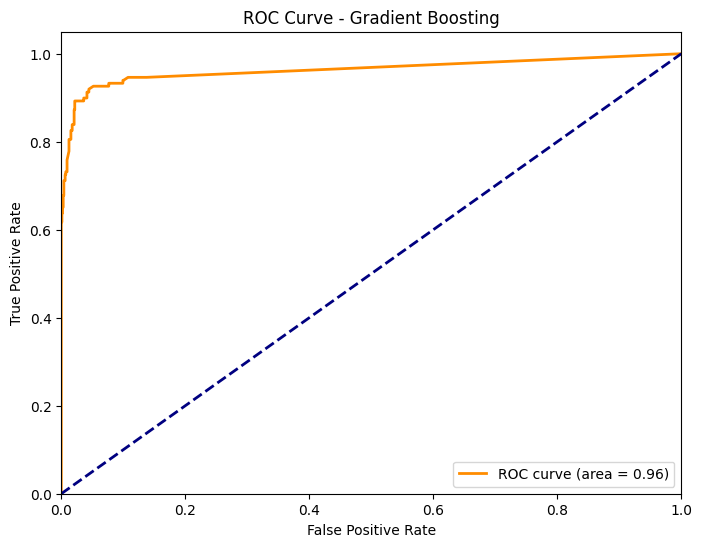

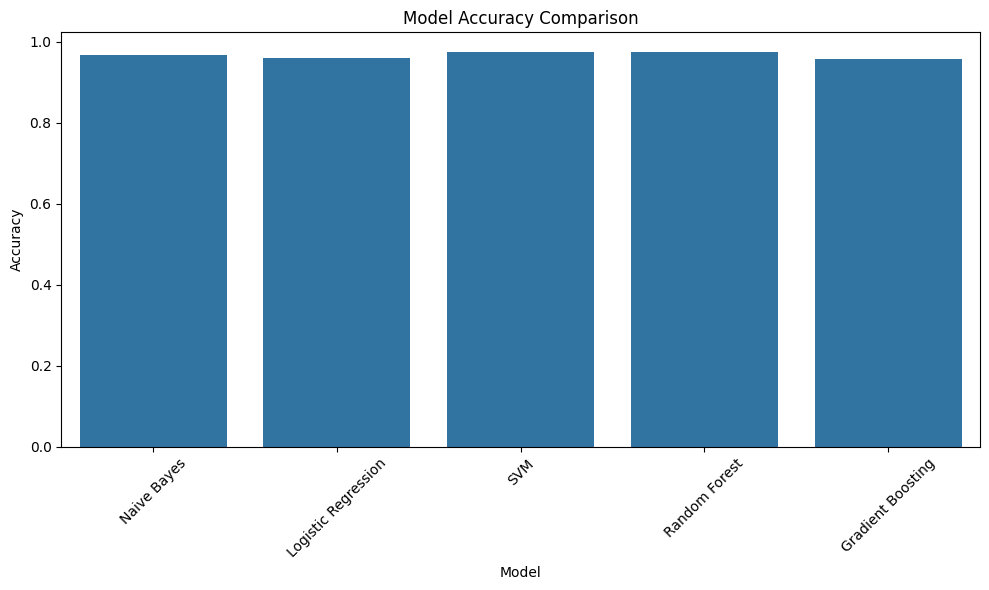

In [41]:
# Model training and evaluation
print("\n=== Model Training and Evaluation ===")

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation metrics
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'],
                yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()


    results[name] = {
        'model': model,
        'accuracy': model.score(X_test, y_test)
    }

# Compare all models
accuracies = [results[name]['accuracy'] for name in models.keys()]
plt.figure(figsize=(10, 6))
sns.barplot(x=list(models.keys()), y=accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Best Model and Accuracy

In [42]:
# Hyperparameter tuning for best model
# Determine the best model based on accuracy
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
print(f"\nBest model: {best_model_name} with accuracy: {results[best_model_name]['accuracy']:.4f}")

print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Naive Bayes':
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
    }
    base_model = MultinomialNB()
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    }
    base_model = SVC(probability=True)
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    base_model = RandomForestClassifier()
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga']
    }
    base_model = LogisticRegression(max_iter=1000)
else:  # Gradient Boosting
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5]
    }
    base_model = GradientBoostingClassifier()

grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train final model with best parameters
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)

# Final evaluation
y_pred_final = final_model.predict(X_test)
print("\nFinal Model Classification Report:")
print(classification_report(y_test, y_pred_final))




Best model: SVM with accuracy: 0.9749

Performing hyperparameter tuning for SVM...
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.9793576019286034

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.99      0.98      0.98      1115



Feature Analysis

In [43]:
# Feature importance analysis
print("\n=== Feature Importance Analysis ===")

if hasattr(final_model, 'feature_importances_'):
    # Get feature names from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get feature importances
    importances = final_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    print("\nTop 20 Important Features:")
    print(feature_importance_df.head(20))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title('Top 20 Features by Importance')
    plt.tight_layout()
    plt.show()
elif best_model_name == 'Logistic Regression':

    feature_names = tfidf_vectorizer.get_feature_names_out()

    coefficients = final_model.coef_[0]

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

    print("\nTop 20 Important Features (by coefficient magnitude):")
    print(coef_df[['Feature', 'Coefficient']].head(20))

    plt.figure(figsize=(12, 8))
    top_positive = coef_df.sort_values('Coefficient', ascending=False).head(10)
    top_negative = coef_df.sort_values('Coefficient', ascending=True).head(10)
    top_coefs = pd.concat([top_positive, top_negative])

    sns.barplot(x='Coefficient', y='Feature', data=top_coefs)
    plt.title('Features with Highest Influence on Classification')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()


=== Feature Importance Analysis ===


Error Analysis

In [44]:
# Step 10: Error analysis
print("\n=== Error Analysis ===")

test_indices = range(len(y_test))

def get_message_from_index(idx):

    try:
        return df['v2'].iloc[idx]
    except:
        return "Message not found"

error_df = pd.DataFrame({
    'Message': [get_message_from_index(i) for i in test_indices],
    'Actual': [label_encoder.inverse_transform([y])[0] for y in y_test],
    'Predicted': [label_encoder.inverse_transform([y])[0] for y in y_pred_final],
})

if hasattr(final_model, 'predict_proba'):
    probas = final_model.predict_proba(X_test)
    error_df['Probability'] = [probas[i, pred] for i, pred in enumerate(y_pred_final)]
else:
    error_df['Probability'] = [0] * len(y_test)

errors = error_df[error_df['Actual'] != error_df['Predicted']]

print(f"\nTotal misclassified messages: {len(errors)} out of {len(error_df)} ({len(errors)/len(error_df)*100:.2f}%)")
print("\nSample of Misclassified Messages:")
for index, row in errors.head(10).iterrows():
    print(f"Message: {row['Message']}")
    print(f"Actual: {row['Actual']}")
    print(f"Predicted: {row['Predicted']}")
    if 'Probability' in row:
        print(f"Probability: {row['Probability']:.4f}")
    print("-" * 80)



=== Error Analysis ===

Total misclassified messages: 17 out of 1115 (1.52%)

Sample of Misclassified Messages:
Message: Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?
Actual: spam
Predicted: ham
Probability: 0.7559
--------------------------------------------------------------------------------
Message: Great! I hope you like your man well endowed. I am  &lt;#&gt;  inches...
Actual: spam
Predicted: ham
Probability: 0.3097
--------------------------------------------------------------------------------
Message: Did u got that persons story
Actual: spam
Predicted: ham
Probability: 0.9843
--------------------------------------------------------------------------------
Message: Yeah you should. I think you can use your gt atm now to register. Not sure but if there's anyway i can help let me know. But when you do be sure you are ready.
Actual: spam
Predicted: ham
Probability: 0.9989
-----------------------------------------------------------------

In [45]:
print("\n=== Saving Model and Components ===")

with open('sms_spam_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("\nModel and preprocessing components saved successfully!")


=== Saving Model and Components ===

Model and preprocessing components saved successfully!


Model's Confusion Matrix


Testing prediction function:
Message: Congratulations! You've won a free iPhone. Claim now at www.freeiphone.com
Prediction: spam
Spam Probability: 0.9787
--------------------------------------------------
Message: Hey, can we meet at 6pm today?
Prediction: ham
Spam Probability: 0.0101
--------------------------------------------------
Message: URGENT: Your bank account has been compromised. Call this number immediately.
Prediction: spam
Spam Probability: 0.9479
--------------------------------------------------
Message: Don't forget to bring milk on your way home.
Prediction: ham
Spam Probability: 0.0014
--------------------------------------------------

Testing simple explanation function:
Message: Congratulations! You've won a free iPhone. Claim now at www.freeiphone.com
Prediction: spam
Spam Probability: 0.9787
Important words:
--------------------------------------------------
Message: Hey, can we meet at 6pm today?
Prediction: ham
Spam Probability: 0.0101
Important words:
-----

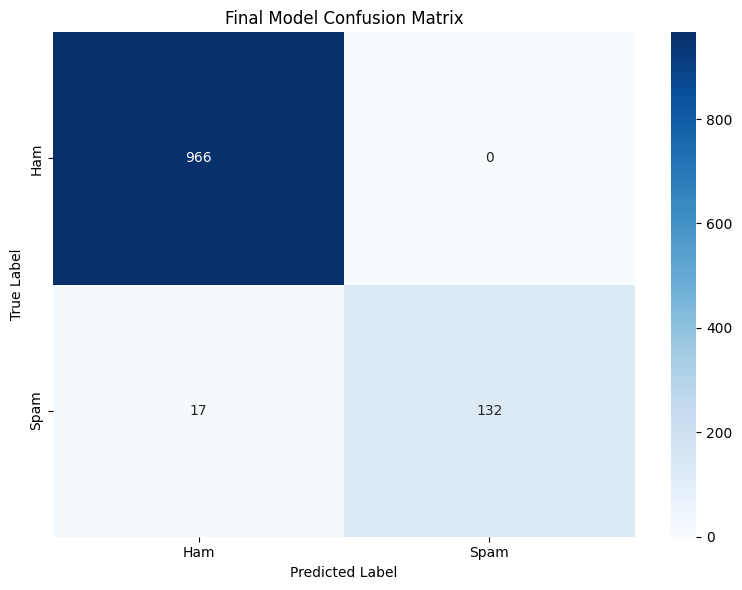

In [47]:
def predict_spam(new_message):
    """
    Predict if a new message is spam or ham

    Parameters:
    new_message (str): The message to classify

    Returns:
    tuple: (prediction label, probability of spam)
    """

    cleaned = clean_text(new_message)
    cleaned = remove_stopwords(cleaned)

    vector = tfidf_vectorizer.transform([cleaned])

    prediction = final_model.predict(vector)[0]

    if hasattr(final_model, 'predict_proba'):
        probability = final_model.predict_proba(vector)[0][1]  # Probability of spam
    else:
        probability = None

    label = label_encoder.inverse_transform([prediction])[0]

    return label, probability

test_messages = [
    "Congratulations! You've won a free iPhone. Claim now at www.freeiphone.com",
    "Hey, can we meet at 6pm today?",
    "URGENT: Your bank account has been compromised. Call this number immediately.",
    "Don't forget to bring milk on your way home."
]

print("\nTesting prediction function:")
for message in test_messages:
    label, probability = predict_spam(message)
    print(f"Message: {message}")
    print(f"Prediction: {label}")
    if probability is not None:
        print(f"Spam Probability: {probability:.4f}")
    print("-" * 50)

def simple_explain_prediction(message):
    """Simple explanation for predictions based on important words"""

    cleaned = clean_text(message)
    words = cleaned.split()


    if hasattr(final_model, 'feature_importances_'):

        feature_names = tfidf_vectorizer.get_feature_names_out()
        importances = final_model.feature_importances_

        word_importance = dict(zip(feature_names, importances))
    elif hasattr(final_model, 'coef_'):

        feature_names = tfidf_vectorizer.get_feature_names_out()
        coefficients = final_model.coef_[0]

        word_importance = dict(zip(feature_names, coefficients))
    else:
        return "Explanation not available for this model type."

    important_words = []
    for word in words:
        if word in word_importance:
            important_words.append((word, word_importance[word]))


    important_words.sort(key=lambda x: abs(x[1]), reverse=True)

    return important_words[:5]


print("\nTesting simple explanation function:")
for message in test_messages:
    label, probability = predict_spam(message)
    important_features = simple_explain_prediction(message)

    print(f"Message: {message}")
    print(f"Prediction: {label}")
    if probability is not None:
        print(f"Spam Probability: {probability:.4f}")
    print("Important words:")
    for word, importance in important_features:
        print(f"  - {word}: {importance:.4f}")
    print("-" * 50)

print("\nSpam SMS Detection project completed successfully!")

# Optional: Display a confusion matrix for the final model
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('Final Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

User Interface

In [48]:
# Spam SMS Detection UI for Google Colab

!pip install -q ipywidgets matplotlib seaborn scikit-learn nltk pandas


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)

def clean_text(text):
    """Basic text cleaning function"""
    if isinstance(text, str):
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

def remove_stopwords(text):
    """Remove stopwords from text"""
    stop_words = set(stopwords.words('english'))
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words])

def stem_text(text):
    """Apply stemming to text"""
    stemmer = PorterStemmer()
    words = text.split()
    return ' '.join([stemmer.stem(word) for word in words])

def lemmatize_text(text):
    """Apply lemmatization to text"""
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])


try:
    with open('sms_spam_model.pkl', 'rb') as f:
        model = pickle.load(f)

    with open('tfidf_vectorizer.pkl', 'rb') as f:
        tfidf_vectorizer = pickle.load(f)

    with open('label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)

    model_loaded = True
    print("✅ Model and components loaded successfully!")

except FileNotFoundError:
    model_loaded = False
    print("❌ Model files not found. Please run the model training code first or upload the model files.")

def predict_spam(message):
    """
    Predict if a message is spam or ham

    Parameters:
    message (str): The message to classify

    Returns:
    tuple: (prediction label, probability of spam)
    """
    if not model_loaded:
        return "Model not loaded", None

    cleaned = clean_text(message)
    cleaned = remove_stopwords(cleaned)

    # Transform with the vectorizer
    vector = tfidf_vectorizer.transform([cleaned])

    prediction = model.predict(vector)[0]

    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(vector)[0][1]  # Probability of spam
    else:
        probability = None

    label = label_encoder.inverse_transform([prediction])[0]

    return label, probability

def explain_prediction(message):
    """Provide explanation for predictions based on important words"""
    if not model_loaded:
        return []

    cleaned = clean_text(message)
    words = cleaned.split()

    if hasattr(model, 'feature_importances_'):

        feature_names = tfidf_vectorizer.get_feature_names_out()
        importances = model.feature_importances_

        word_importance = dict(zip(feature_names, importances))
    elif hasattr(model, 'coef_'):

        feature_names = tfidf_vectorizer.get_feature_names_out()
        coefficients = model.coef_[0]

        word_importance = dict(zip(feature_names, coefficients))
    else:
        return []

    important_words = []
    for word in words:
        if word in word_importance:
            important_words.append((word, word_importance[word]))

    # Sort by absolute importance
    important_words.sort(key=lambda x: abs(x[1]), reverse=True)

    # Return top words
    return important_words[:5]

# Creating UI components
# Title and description styles
title_html = """
<div style="background-color:#4D77FF; padding:15px; border-radius:10px; margin-bottom:20px">
    <h1 style="color:white; text-align:center">📱 SMS Spam Detector</h1>
    <h3 style="color:white; text-align:center">Enter a message to classify it as spam or ham</h3>
</div>
"""

# Message input
message_input = widgets.Textarea(
    value='',
    placeholder='Type or paste your SMS message here...',
    description='Message:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='100px')
)

# Analysis button
analyze_button = widgets.Button(
    description='Analyze Message',
    button_style='primary',
    tooltip='Click to analyze the message',
    icon='check'
)


result_output = widgets.Output()

# Sample messages dropdown
sample_messages = [
    "Select a sample message...",
    "Congratulations! You've won a $1000 gift card. To claim visit: www.prize-winner.com now!",
    "Hey, can we meet for coffee at 5pm? Let me know if that works.",
    "URGENT: Your account has been suspended. Call our security team: 1-800-555-1234",
    "Don't forget to pick up milk on your way home, thanks!",
    "FREE entry to 100s of clubs this weekend! Text PARTY to 71011 to get your free passes!"
]
sample_dropdown = widgets.Dropdown(
    options=sample_messages,
    value=sample_messages[0],
    description='Samples:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)

history_output = widgets.Output()

message_history = []

def on_button_click(b):
    with result_output:
        clear_output()

        message = message_input.value

        if not message.strip():
            print("⚠️ Please enter a message to analyze")
            return

        message_history.append(message)

        print("🔍 Analyzing message...")


        label, probability = predict_spam(message)


        explanations = explain_prediction(message)


        clear_output()


        if label == 'spam':
            result_color = '#FF6B6B'
            result_emoji = '🚨'
            result_text = 'SPAM'
        else:
            result_color = '#4ECDC4'
            result_emoji = '✅'
            result_text = 'HAM (legitimate)'

        result_html = f"""
        <div style="margin-top:20px; padding:15px; border-radius:10px; border:2px solid {result_color}">
            <h2 style="color:{result_color}; text-align:center">{result_emoji} Prediction: {result_text} {result_emoji}</h2>

            <div style="background-color:#f5f5f5; padding:10px; border-radius:5px; margin-top:10px">
                <p style="font-size:16px"><b>Message:</b> {message}</p>
            </div>
        """

        if probability is not None:
            # Create a visual probability bar
            bar_width = int(probability * 100)
            result_html += f"""
            <div style="margin-top:15px">
                <p><b>Spam Probability:</b> {probability:.2%}</p>
                <div style="width:100%; background-color:#e0e0e0; height:20px; border-radius:10px">
                    <div style="width:{bar_width}%; background-color:{result_color}; height:20px; border-radius:10px"></div>
                </div>
            </div>
            """

        if explanations:
            result_html += """
            <div style="margin-top:15px">
                <p><b>Key words influencing this prediction:</b></p>
                <ul>
            """

            for word, importance in explanations:
                color = "#FF6B6B" if importance > 0 else "#4ECDC4"
                direction = "increases" if importance > 0 else "decreases"
                result_html += f"<li><b style='color:{color}'>{word}</b>: {direction} spam probability by {abs(importance):.4f}</li>"

            result_html += """
                </ul>
            </div>
            """

        result_html += "</div>"
        display(HTML(result_html))

        # Update history
        with history_output:
            clear_output()
            if message_history:
                history_html = """
                <div style="margin-top:20px">
                    <h3>Recent Messages History</h3>
                    <table style="width:100%; border-collapse:collapse">
                        <tr style="background-color:#f5f5f5">
                            <th style="padding:8px; text-align:left">#</th>
                            <th style="padding:8px; text-align:left">Message</th>
                            <th style="padding:8px; text-align:left">Prediction</th>
                        </tr>
                """

                for i, msg in enumerate(reversed(message_history[-5:])):
                    lbl, prob = predict_spam(msg)
                    color = "#FF6B6B" if lbl == "spam" else "#4ECDC4"
                    history_html += f"""
                        <tr>
                            <td style="padding:8px; border-bottom:1px solid #ddd">{len(message_history) - i}</td>
                            <td style="padding:8px; border-bottom:1px solid #ddd">{msg[:50]}{"..." if len(msg) > 50 else ""}</td>
                            <td style="padding:8px; border-bottom:1px solid #ddd; color:{color}"><b>{lbl.upper()}</b></td>
                        </tr>
                    """

                history_html += """
                    </table>
                </div>
                """
                display(HTML(history_html))

def on_sample_change(change):
    if change['new'] != sample_messages[0]:
        message_input.value = change['new']

        sample_dropdown.value = sample_messages[0]

# Connect event handlers
analyze_button.on_click(on_button_click)
sample_dropdown.observe(on_sample_change, names='value')

# Creating the UI layout
def create_ui():

    display(HTML(title_html))

    if not model_loaded:
        missing_model_html = """
        <div style="background-color:#FFCCCC; padding:15px; border-radius:10px; margin-bottom:20px">
            <h3 style="color:#CC0000">⚠️ Model Not Found</h3>
            <p>Please run your model training code first or upload the following files to continue:</p>
            <ul>
                <li><code>sms_spam_model.pkl</code> - Your trained classifier model</li>
                <li><code>tfidf_vectorizer.pkl</code> - The text vectorizer</li>
                <li><code>label_encoder.pkl</code> - The label encoder</li>
            </ul>
        </div>
        """
        display(HTML(missing_model_html))

    instructions_html = """
    <div style="background-color:#F5F5F5; padding:15px; border-radius:10px; margin-bottom:20px; color:black">
        <h3>How to use:</h3>
        <ol>
            <li>Enter a message in the text area below or select a sample message</li>
            <li>Click "Analyze Message" to see if it's spam or legitimate (ham)</li>
            <li>View the prediction results and explanation</li>
        </ol>
    </div>
"""

    display(HTML(instructions_html))

    display(widgets.HBox([sample_dropdown]))

    display(message_input)

    display(analyze_button)

    display(result_output)

    display(history_output)

    footer_html = """
    <div style="margin-top:30px; padding-top:20px; border-top:1px solid #ccc; text-align:center; font-size:12px; color:#666">
        SMS Spam Detection Model UI | Created using Google Colab and Python
    </div>
    """
    display(HTML(footer_html))

#  Run the UI
create_ui()

if not model_loaded:
    upload_html = """
    <div style="margin-top:20px; padding:15px; border-radius:10px; border:1px dashed #ccc">
        <h3>Upload Model Files</h3>
        <p>If you have already trained your model, you can upload the required files here:</p>
    </div>
    """
    display(HTML(upload_html))

    file_upload = widgets.FileUpload(
        accept='.pkl',
        multiple=True,
        description='Upload files',
        layout=widgets.Layout(width='300px')
    )

    display(file_upload)

    upload_button = widgets.Button(
        description='Process Uploads',
        button_style='info',
        tooltip='Process uploaded files',
        icon='upload'
    )

    upload_output = widgets.Output()
    display(upload_button, upload_output)

    def on_upload_button_click(b):
        with upload_output:
            clear_output()

            if not file_upload.value:
                print("⚠️ Please upload files first")
                return

            print("Processing uploads...")

            for filename, data in file_upload.value.items():
                with open(filename, 'wb') as f:
                    f.write(data['content'])
                print(f"✅ Saved: {filename}")

            print("\n🔄 Please refresh the UI to use the uploaded files")

            reload_button = widgets.Button(
                description='Reload UI',
                button_style='success',
                icon='refresh'
            )

            def on_reload(b):

                display(HTML("<script>Jupyter.notebook.execute_cell_range(Jupyter.notebook.get_selected_index(), Jupyter.notebook.get_selected_index()+1)</script>"))

            reload_button.on_click(on_reload)
            display(reload_button)

    upload_button.on_click(on_upload_button_click)

✅ Model and components loaded successfully!


Textarea(value='', description='Message:', layout=Layout(height='100px', width='100%'), placeholder='Type or p…

Button(button_style='primary', description='Analyze Message', icon='check', style=ButtonStyle(), tooltip='Clic…

Output()

Output()